<a href="https://colab.research.google.com/github/himawanbayu/nlp-team-3/blob/main/pilot_test.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Pilot Study
author: Hongxu Zhou  

This notebook aims to run the complete pipeline for testing the auto-generated distractors and compare the results with original SciQ dataset.   
This one serves as a minimal viable product. It uses:  
* BERT-base-uncased as the testing model
* the first 100 questions with distractors denerataed by llama3.2 1B (credits go to Jelmer)  

**Known issues:**
* 27/100 questions have at least two distractors duplicated
* Some contexts are quite long, exceeding the 512 max length of BERT, but this MVP does not use sliding window

In [1]:
# Multiple Choice Question Distractor Evaluation with BERT
# Comparing original SciQ distractors with Llama3.2 generated distractors

import pandas as pd
import numpy as np
import torch
import random
from transformers import BertTokenizer, BertForMultipleChoice
from google.colab import drive
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

## Data loading & random seeds

In [ ]:
# Set random seed for reproducibility
random.seed(42)
np.random.seed(42)
torch.manual_seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(42)

# Mount Google Drive to access datasets
drive.mount('/content/drive')

# Load the dataset (adjust path as needed)
dataset_path = '/content/drive/MyDrive/SciQ_personal/first100_llama3.2_generated - Sheet1.tsv'
pilot_df = pd.read_csv(dataset_path, sep='\t')

# Display the first few rows of the dataset
pilot_df.head()

## Taking the test

In [11]:
def evaluate_bert_on_mcq(dataframe, use_generated_distractors=False, max_length=512):
    # Initialize model and tokenizer
    tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
    model = BertForMultipleChoice.from_pretrained('bert-base-uncased')

    # Move model to GPU if available
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)

    correct_count = 0
    results = []

    # Process each question
    for _, row in tqdm(dataframe.iterrows(), total=len(dataframe)):
        question = row['question']
        context = str(row['support'])  # Ensure it's a string
        correct_answer = row['correct_answer']

        # Select either original or generated distractors
        if use_generated_distractors:
            distractors = [
                row['sys_distractor1'],
                row['sys_distractor2'],
                row['sys_distractor3']
            ]
        else:
            distractors = [
                row['ref_distractor1'],
                row['ref_distractor2'],
                row['ref_distractor3']
            ]

        # Combine correct answer and distractors
        choices = [correct_answer] + distractors

        # Randomize the order of choices
        correct_index = 0  # Current position of correct answer
        shuffled_indices = list(range(len(choices)))
        random.shuffle(shuffled_indices)

        # Track where the correct answer ends up after shuffling
        new_correct_index = shuffled_indices.index(correct_index)
        shuffled_choices = [choices[i] for i in shuffled_indices]

        # Format inputs in the way BertForMultipleChoice expects
        # We need to create input pairs for each choice
        encoded_inputs = []

        for choice in shuffled_choices:
            # Format as: [CLS] context [SEP] question + choice [SEP]
            # This is the expected format for BERT sequence classification
            encoded_input = tokenizer.encode_plus(
                context,
                question + " " + choice,
                add_special_tokens=True,
                max_length=max_length,
                padding='max_length',
                truncation=True,
                return_tensors='pt'
            )
            encoded_inputs.append({
                'input_ids': encoded_input['input_ids'].squeeze(),
                'attention_mask': encoded_input['attention_mask'].squeeze(),
                'token_type_ids': encoded_input['token_type_ids'].squeeze()
            })

        # Stack all inputs
        input_ids = torch.stack([encoded_input['input_ids'] for encoded_input in encoded_inputs]).unsqueeze(0).to(device)
        attention_mask = torch.stack([encoded_input['attention_mask'] for encoded_input in encoded_inputs]).unsqueeze(0).to(device)
        token_type_ids = torch.stack([encoded_input['token_type_ids'] for encoded_input in encoded_inputs]).unsqueeze(0).to(device)

        # Get model outputs
        with torch.no_grad():
            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask,
                token_type_ids=token_type_ids
            )

        # Get prediction and confidence scores
        logits = outputs.logits
        probabilities = torch.nn.functional.softmax(logits, dim=1).cpu().numpy()[0]
        predicted_idx = logits.argmax().item()

        # Check if prediction is correct
        is_correct = (predicted_idx == new_correct_index)
        if is_correct:
            correct_count += 1

        # Save result details
        result = {
            'question': question,
            'correct_answer': correct_answer,
            'shuffled_choices': shuffled_choices,
            'correct_index': new_correct_index,
            'predicted_index': predicted_idx,
            'is_correct': is_correct,
            'confidence_scores': probabilities.tolist(),
            'confidence_in_correct': probabilities[new_correct_index],
            'confidence_in_prediction': probabilities[predicted_idx]
        }
        results.append(result)

    # Calculate accuracy
    accuracy = correct_count / len(dataframe)

    # Calculate average confidence in correct answers
    avg_confidence_correct = np.mean([r['confidence_in_correct'] for r in results])

    # Clean up to free memory
    del model
    if torch.cuda.is_available():
        torch.cuda.empty_cache()

    return {
        'accuracy': accuracy,
        'correct_count': correct_count,
        'total_questions': len(dataframe),
        'avg_confidence_correct': avg_confidence_correct,
        'detailed_results': results
    }

**Please be aware:**  
There are some trick issues associated with [`BertForMultipleChoice`](https://huggingface.co/docs/transformers/v4.50.0/en/model_doc/bert#transformers.BertForMultipleChoice).  
I managed to solve them with Claude's help. But please double-check the code because some parts are machine-generated.

In [12]:
# Run evaluation with original distractors
print("Evaluating BERT on questions with original distractors...")
original_results = evaluate_bert_on_mcq(pilot_df, use_generated_distractors=False)

# Run evaluation with generated distractors
print("\nEvaluating BERT on questions with Llama3.2 generated distractors...")
generated_results = evaluate_bert_on_mcq(pilot_df, use_generated_distractors=True)

Evaluating BERT on questions with original distractors...


Some weights of BertForMultipleChoice were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


  0%|          | 0/100 [00:00<?, ?it/s]

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pai


Evaluating BERT on questions with Llama3.2 generated distractors...


Some weights of BertForMultipleChoice were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


  0%|          | 0/100 [00:00<?, ?it/s]

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pai

## Evaluation

In [13]:
# Compare results
print("\n=== Results Comparison ===")
print(f"Original distractors accuracy: {original_results['accuracy']:.2f} ({original_results['correct_count']}/{original_results['total_questions']})")
print(f"Generated distractors accuracy: {generated_results['accuracy']:.2f} ({generated_results['correct_count']}/{generated_results['total_questions']})")
print(f"Average confidence in correct answer (original): {original_results['avg_confidence_correct']:.4f}")
print(f"Average confidence in correct answer (generated): {generated_results['avg_confidence_correct']:.4f}")




=== Results Comparison ===
Original distractors accuracy: 0.36 (36/100)
Generated distractors accuracy: 0.53 (53/100)
Average confidence in correct answer (original): 0.2482
Average confidence in correct answer (generated): 0.2496


## Visualisation

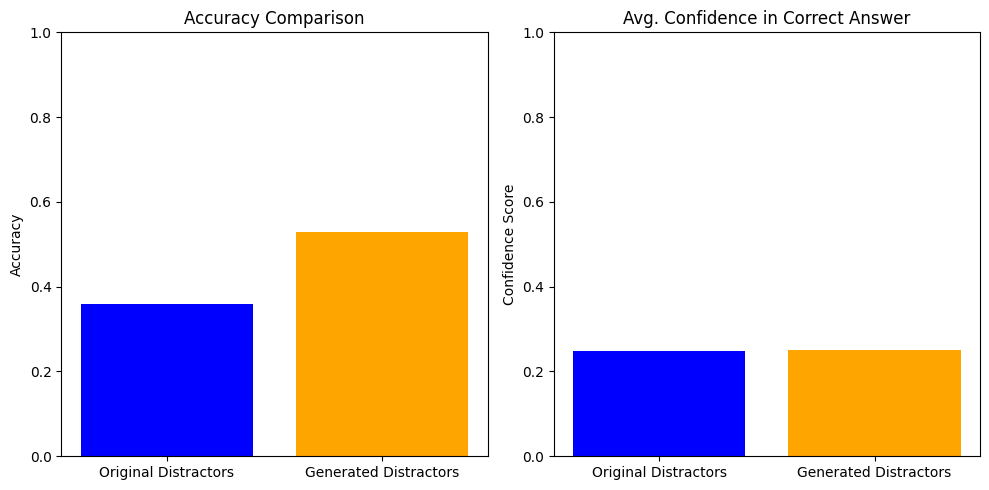

Detailed results saved to 'mcq_evaluation_results.csv'


In [14]:
# Visualise the results
plt.figure(figsize=(10, 5))

# Accuracy comparison
plt.subplot(1, 2, 1)
accuracies = [original_results['accuracy'], generated_results['accuracy']]
plt.bar(['Original Distractors', 'Generated Distractors'], accuracies, color=['blue', 'orange'])
plt.ylim(0, 1)
plt.title('Accuracy Comparison')
plt.ylabel('Accuracy')

# Confidence comparison
plt.subplot(1, 2, 2)
confidences = [original_results['avg_confidence_correct'], generated_results['avg_confidence_correct']]
plt.bar(['Original Distractors', 'Generated Distractors'], confidences, color=['blue', 'orange'])
plt.ylim(0, 1)
plt.title('Avg. Confidence in Correct Answer')
plt.ylabel('Confidence Score')

plt.tight_layout()
plt.savefig('distractor_comparison.png')
plt.show()

# Save detailed results for further analysis
results_df = pd.DataFrame({
    'question': [r['question'] for r in original_results['detailed_results']],
    'correct_original': [r['is_correct'] for r in original_results['detailed_results']],
    'correct_generated': [r['is_correct'] for r in generated_results['detailed_results']],
    'conf_original': [r['confidence_in_correct'] for r in original_results['detailed_results']],
    'conf_generated': [r['confidence_in_correct'] for r in generated_results['detailed_results']]
})

results_df.to_csv('mcq_evaluation_results.csv', index=False)
print("Detailed results saved to 'mcq_evaluation_results.csv'")

For multiple-choice questions with 4 options (1 correct answer + 3 distractors), random guessing would give 25% accuracy. So the model is actually performing better than random guessing on both test papers:

* Original distractors: 36% (11 percentage points above random)
* Generated distractors: 53% (28 percentage points above random)  

This suggests that:

1. The original SciQ distractors are more challenging and effective at confusing the model
2. The Llama-generated distractors are easier for the model to distinguish from the correct answer -- explainable since 30% of the questions have duplicated distractors  

The confidence scores are almost identical between original and generated tests. The close-to-0.25 values indicate that despite getting more answers right with the generated distractors, the model isn't more confident in its choices.

This fact has important implications for distractor quality:

* Original SciQ distractors: These appear to be *genuinely* challenging. They create real confusion for the model (low accuracy) while keeping confidence low (near random).
* Generated distractors: Despite yielding higher accuracy, they aren't making the model more confident. This suggests they may be less plausible as alternatives, allowing the model to eliminate them without being truly confident in the correct answer.

However, regarding that mutiple contexts are truncated, it is too early to judge the quality of the generated distractors without the whole picture.

Good distractors should be plausible enough to create genuine uncertainty. The fact that confidence stays low across both tests, but accuracy varies significantly, suggests the original SciQ distractors are more effective at creating that genuine uncertainty.